<a href="https://colab.research.google.com/github/ebhawana/music-genre-classification-CNN-/blob/main/Music_Genre_Classification_(CNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install librosa #librosa for analysing music and audio files, extracting mel-spectrograms, MFCCs, visualising audio signals
!apt-get update
!apt-get install ffmpeg libsndfile1 -y
!pip install audiomentations

Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,759 kB]
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,740 kB]
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:9 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,246 kB]
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:12 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,984 kB]
Get:13 https://r2u.sta

In [2]:
import librosa#This is a powerful library for audio analysis. It provides functions for loading audio files, extracting features like Mel-spectrograms, and other audio processing tasks
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import random
from sklearn.model_selection import train_test_split
import pandas as pd


In [3]:
#Fix seeds
os.environ['PYTHONHASHSEED'] = '42'
os.environ['TF_DETERMINISTIC_OPS'] = '1'
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andradaolteanu/gtzan-dataset-music-genre-classification")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/gtzan-dataset-music-genre-classification


In [5]:
!ls -R {path}


/kaggle/input/gtzan-dataset-music-genre-classification:
Data

/kaggle/input/gtzan-dataset-music-genre-classification/Data:
features_30_sec.csv  features_3_sec.csv  genres_original  images_original

/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original:
blues  classical  country  disco  hiphop  jazz	metal  pop  reggae  rock

/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/blues:
blues.00000.wav  blues.00025.wav  blues.00050.wav  blues.00075.wav
blues.00001.wav  blues.00026.wav  blues.00051.wav  blues.00076.wav
blues.00002.wav  blues.00027.wav  blues.00052.wav  blues.00077.wav
blues.00003.wav  blues.00028.wav  blues.00053.wav  blues.00078.wav
blues.00004.wav  blues.00029.wav  blues.00054.wav  blues.00079.wav
blues.00005.wav  blues.00030.wav  blues.00055.wav  blues.00080.wav
blues.00006.wav  blues.00031.wav  blues.00056.wav  blues.00081.wav
blues.00007.wav  blues.00032.wav  blues.00057.wav  blues.00082.wav
blues.00008.wav  blues.00033.wav 

In [6]:
def extract_mel_spectrogram(file_path, n_mels=128):#no. of melbands tobe 128
    y, sr = librosa.load(file_path, duration=30)#load the 30 sec of audio and return audio time series as numpy array and sr sampling rate
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)# line computes the Mel-spectrogram of the audio time series y with the given sampling rate sr and the specified number of Mel bands n_mels
    S_dB = librosa.power_to_db(S, ref=np.max)#convert the power spectogram to decible scale.
    return S_dB


#The function returns the Mel-spectrogram in decibels.

In [7]:
genres = 'blues classical country disco hiphop metal pop reggae rock'.split()#jazz
X = []
y = []

dataset_root_path = os.path.join(path, 'Data', 'genres_original')

for i, genre in enumerate(genres):
      genre_folder_path = os.path.join(dataset_root_path, genre)
      print(f"Processing genre: {genre} at {genre_folder_path}")
      for filename in os.listdir(genre_folder_path):
        if filename.endswith(".wav"):
            path = os.path.join(genre_folder_path, filename)
            spectrogram = extract_mel_spectrogram(path)
            if spectrogram.shape[1] >= 640:
                spectrogram = spectrogram[:, :640]
                X.append(spectrogram)
                y.append(i)




Processing genre: blues at /kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/blues
Processing genre: classical at /kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/classical
Processing genre: country at /kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/country
Processing genre: disco at /kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/disco
Processing genre: hiphop at /kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/hiphop
Processing genre: metal at /kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/metal
Processing genre: pop at /kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/pop
Processing genre: reggae at /kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/reggae
Processing genre: rock at /kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/rock


In [8]:
x = np.array(X)[..., np.newaxis]  # (samples, 128, 640, 1)#processed audio data
y = tf.keras.utils.to_categorical(y, num_classes=9)#

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [9]:
import audiomentations
from audiomentations.core.composition import Compose
from audiomentations import AddGaussianNoise, TimeStretch, PitchShift, Shift

augment = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015),
    TimeStretch(min_rate=0.8, max_rate=1.25),
    PitchShift(min_semitones=-2, max_semitones=2),
    Shift(min_shift=-0.5, max_shift=0.5)
])

In [86]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(128, 640, 1)),
    #1st layer
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),#achieve better performance by controlling the distribution of activations within the network.
    tf.keras.layers.MaxPooling2D((2, 2)),
    #2nd layer
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    #tf.keras.layers.Flatten(),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(9, activation='softmax')
])



In [87]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [88]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 126, 638, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 126, 638, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 63, 319, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 61, 317, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 61, 317, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 30, 158, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,681 (112.04 KB)

 Trainable params: 28,489 (111.29 KB)

 Non-trainable params: 192 (768.00 B)

In [89]:
# Building the custom Callbacks
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get("val_accuracy") > 0.70):
      print("\nReached 70% accurcy so stopping the execution of the program!")
      self.model.stop_training = True

# Instantiation

callbacks = myCallback()#last patterns

In [91]:
#If the val_loss doesn't improve for 3 consecutive epochs, training will stop.
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
#save the model when the validation accuracy increases.
check_point = tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_accuracy', mode='max')
#the learning rate will be reduced to half if the monitored metric (val_loss) does not improve for 2 consecutive epochs.
lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

In [92]:
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), batch_size=32, callbacks=[callbacks])


Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 199ms/step - accuracy: 0.1318 - loss: 2.3832 - val_accuracy: 0.0889 - val_loss: 3.0091
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 156ms/step - accuracy: 0.1928 - loss: 2.1399 - val_accuracy: 0.1185 - val_loss: 2.8003
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 161ms/step - accuracy: 0.2215 - loss: 2.0274 - val_accuracy: 0.0741 - val_loss: 2.7475
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - accuracy: 0.2729 - loss: 1.9561 - val_accuracy: 0.0741 - val_loss: 2.7018
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 160ms/step - accuracy: 0.2788 - loss: 1.9159 - val_accuracy: 0.0741 - val_loss: 2.5657
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 164ms/step - accuracy: 0.3073 - loss: 1.8713 - val_accuracy: 0.0741 - val_loss: 2.4537
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 159ms/step - accuracy: 0.3441 - loss: 1.8364 - val_accuracy: 0.0741 - val_loss: 2.3264
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 160ms/step - accuracy: 0.3625 - loss: 1.7894 - val_accu

In [93]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.2f}")


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.7062 - loss: 1.0436
Test Accuracy: 0.71


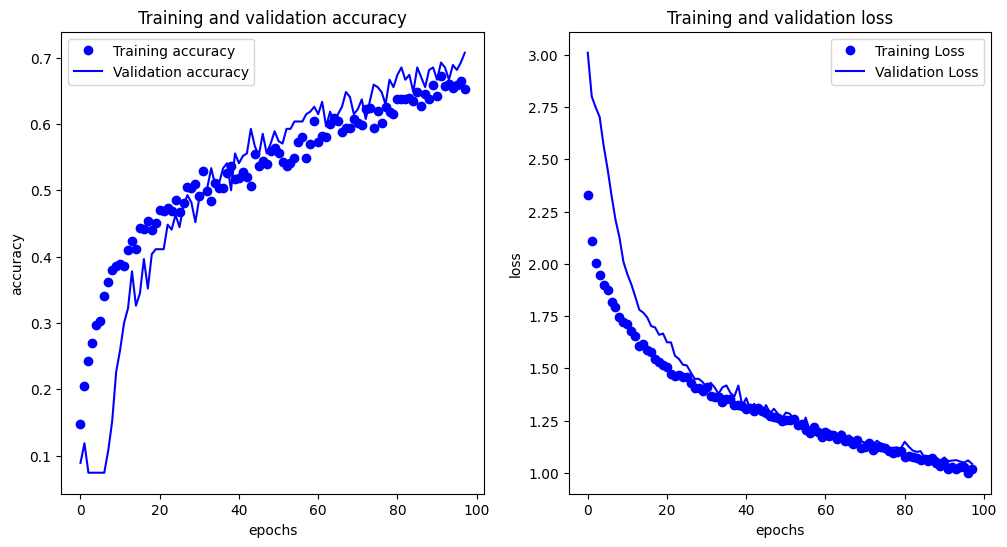

In [94]:
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    fig, ax = plt.subplots(1,2, figsize=(12, 6))
    ax[0].plot(epochs, acc, 'bo', label='Training accuracy')
    ax[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
    ax[0].set_title('Training and validation accuracy')
    ax[0].set_xlabel('epochs')
    ax[0].set_ylabel('accuracy')
    ax[0].legend()

    ax[1].plot(epochs, loss, 'bo', label='Training Loss')
    ax[1].plot(epochs, val_loss, 'b', label='Validation Loss')
    ax[1].set_title('Training and validation loss')
    ax[1].set_xlabel('epochs')
    ax[1].set_ylabel('loss')
    ax[1].legend()

    plt.show()
    #fix seeds

    #early stoping(past steps)

In [95]:

# on unseen data
def classify_unseen_audio(model, file_path): #learning scheduler and early stopping
  spectrogram = extract_mel_spectrogram(file_path)
  if spectrogram.shape[1] >= 640:
    spectrogram = spectrogram[:, :640]
  else:
      # Pad or handle shorter audio files as appropriate for your model
      padding_width = 640 - spectrogram.shape[1]
      spectrogram = np.pad(spectrogram, pad_width=((0, 0), (0, padding_width)), mode='constant')

  spectrogram = np.array(spectrogram)[np.newaxis, ..., np.newaxis] # Reshape for model input

  prediction = model.predict(spectrogram)
  predicted_class_index = np.argmax(prediction)
  predicted_genre = genres[predicted_class_index]

  return predicted_genre

In [98]:
unseen_audio_file = '/content/drive/MyDrive/classical.wav'
predicted_genre = classify_unseen_audio(model, unseen_audio_file)
print(f"The predicted genre for the unseen audio is: {predicted_genre}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
The predicted genre for the unseen audio is: classical
